In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
# %pip install scikit-learn --quiet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
sns.set(style="whitegrid")

In [29]:
# read data
df = pd.read_excel("Dataset.xlsx", sheet_name=0)
df.head()

,student_id,name,class,study,gpa,greek,off_campus,distance_to_campus,gender,sprinklered,coverage,claim_id,amount,risk_tier,holdout
0,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Additional Living Expense,0,0.0,2,False
1,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Guest Medical,0,0.0,2,False
2,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Liability,0,0.0,2,False
3,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Personal Property,0,0.0,2,False
4,2,"Reddy, Dawna",Junior,Science,0.609616,Non-greek,On campus,0.0,Female,True,Additional Living Expense,0,0.0,2,False


In [30]:
df_loss = df[df["amount"] > 0].copy()

# 95th percentile tail threshold
threshold = df_loss["amount"].quantile(0.95)
df_loss["large_loss"] = (df_loss["amount"] > threshold).astype(int)


In [31]:
formula = """
large_loss ~ 
C(coverage) 
+ C(greek, Treatment(reference='Non-greek'))
+ C(off_campus, Treatment(reference='On campus'))
+ C(sprinklered, Treatment(reference=True))
"""


In [32]:
model = smf.logit(
    formula=formula,
    data=df_loss
).fit()

print(model.summary())


         Current function value: 0.099811
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             large_loss   No. Observations:                 1819
Model:                          Logit   Df Residuals:                     1812
Method:                           MLE   Df Model:                            6
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.4974
Time:                        20:15:49   Log-Likelihood:                -181.56
converged:                      False   LL-Null:                       -361.25
Covariance Type:            nonrobust   LLR p-value:                 1.495e-74
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                 

c:\Users\ziang\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
coef = model.params
or_table = pd.DataFrame({
    "variable": coef.index,
    "coef": coef.values,
    "odds_ratio": np.exp(coef.values)
})

or_table

,variable,coef,odds_ratio
0,Intercept,-6.538592,1.446524e-03
1,C(coverage)[T.Guest Medical],3.747451,4.241285e+01
2,C(coverage)[T.Liability],1.710561,5.532066e+00
3,C(coverage)[T.Personal Property],-18.848625,6.518479e-09
4,"C(greek, Treatment(reference='Non-greek'))[T.G...",2.283988,9.815749e+00
5,"C(off_campus, Treatment(reference='On campus')...",1.327465,3.771470e+00
6,"C(sprinklered, Treatment(reference=True))[T.Fa...",1.323216,3.755480e+00


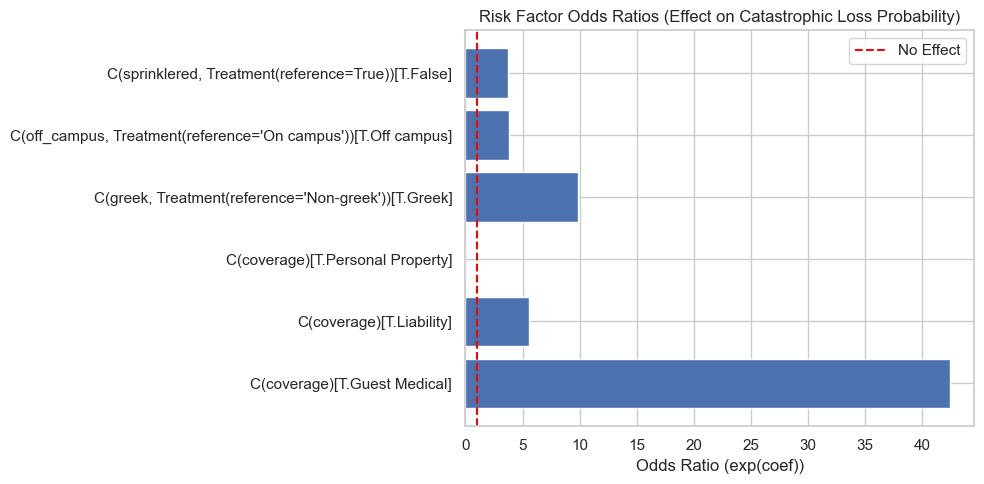

In [34]:
plt.figure(figsize=(10, 5))

mask = or_table["variable"] != "Intercept"
plot_df = or_table[mask].copy()

plt.barh(plot_df["variable"], plot_df["odds_ratio"])
plt.axvline(1.0, color="red", linestyle="--", label="No Effect")

plt.xlabel("Odds Ratio (exp(coef))")
plt.title("Risk Factor Odds Ratios (Effect on Catastrophic Loss Probability)")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# 创建预测用的数据表（所有 coverage × sprinkler 组合）
unique_cov = df_loss["coverage"].unique()
unique_spr = df_loss["sprinklered"].unique()

grid = pd.DataFrame([
    {"coverage": c, "sprinklered": s, 
     "greek": "Non-greek", "off_campus": "On campus"}  # baseline
    for c in unique_cov for s in unique_spr
])

grid["pred_prob"] = model.predict(grid)


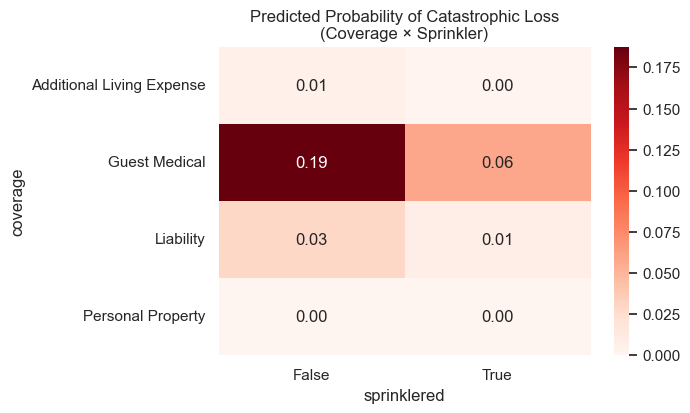

In [36]:
pivot = grid.pivot(index="coverage", columns="sprinklered", values="pred_prob")

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, cmap="Reds", fmt=".2f")
plt.title("Predicted Probability of Catastrophic Loss\n(Coverage × Sprinkler)")
plt.show()

* Stress Testing (just for check, the code is in file: `stress_test.ipynb`)

In [37]:
df_loss.shape
df_loss["large_loss"].mean()
df_loss.head()


,student_id,name,class,study,gpa,greek,off_campus,distance_to_campus,gender,sprinklered,coverage,claim_id,amount,risk_tier,holdout,large_loss
40,11,"Leigh, Shelley",Sophomore,Other,0.981003,Non-greek,Off campus,10.083255,Female,True,Personal Property,1,990.596391,1,False,0
84,22,"Stark, Najee",Senior,Science,1.874571,Greek,On campus,0.000000,Male,True,Personal Property,2,1172.942616,3,False,0
104,27,"Roy, Dylan",Sophomore,Business,2.582975,Greek,On campus,0.000000,Male,True,Personal Property,3,2106.469682,1,False,0
112,29,"Mora, Yesica",Senior,Business,2.448340,Non-greek,Off campus,0.568290,Female,True,Liability,4,6943.265254,3,False,0
128,33,"Ignacio, Austin",Senior,Business,2.843812,Non-greek,On campus,0.000000,Did not respond,True,Guest Medical,5,7197.105825,3,False,0


In [38]:
df_loss["large_loss"].mean()

np.float64(0.05002748763056625)

In [39]:
df_loss.groupby("greek")["large_loss"].mean()



greek
Greek        0.091200
Non-greek    0.028476
Name: large_loss, dtype: float64

In [40]:
df_loss.groupby("off_campus")["large_loss"].mean()


off_campus
Off campus    0.075067
On campus     0.032619
Name: large_loss, dtype: float64

In [41]:
df_loss.groupby("sprinklered")["large_loss"].mean()


sprinklered
False    0.079566
True     0.037125
Name: large_loss, dtype: float64

In [42]:
df_loss.groupby("coverage")["large_loss"].mean()

coverage
Additional Living Expense    0.022727
Guest Medical                0.300429
Liability                    0.105882
Personal Property            0.000000
Name: large_loss, dtype: float64